In [1]:
# My custom library of photoelastic tools
import sys
sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100

from pepe.simulate import genSyntheticResponse
from pepe.preprocess import circularMask, mergeMasks, crossMask, rectMask
from pepe.analysis import detectWallContacts

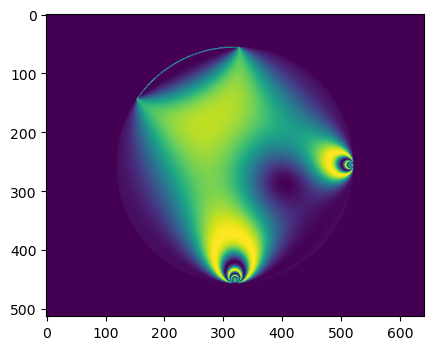

In [2]:
imageShape = (513, 641)
center = np.array([imageShape[0]/2, imageShape[1]/2], dtype=np.int64)
radius = 201

# Material properties
fSigma = 100.
pxPerMeter = 10000.
brightfield = False

# The (discrete) forces acting on the particle
discreteForceArr = np.array([.5, .3])
discreteBetaArr = np.array([0, np.pi/2])
discreteAlphaArr = np.array([0., 0.])

# Now the continuous forces
totalMagnitude = 1.
betaRange = [-np.pi/2 - .6, -np.pi/2 - 1.6]
alpha = 0
resolution = 100

continuousForceArr = totalMagnitude/resolution * np.linspace(.99, 1.01, resolution)
continuousBetaArr = np.linspace(betaRange[0], betaRange[1], resolution)
continuousAlphaArr = np.zeros(resolution) + alpha

totalForceArr = np.concatenate((discreteForceArr, continuousForceArr))
totalBetaArr = np.concatenate((discreteBetaArr, continuousBetaArr))
totalAlphaArr = np.concatenate((discreteAlphaArr, continuousAlphaArr))

particleImg = genSyntheticResponse(totalForceArr, totalAlphaArr, totalBetaArr,
                                   fSigma, radius, pxPerMeter, brightfield, imageSize=imageShape, center=center)

plt.imshow(particleImg)
plt.show()

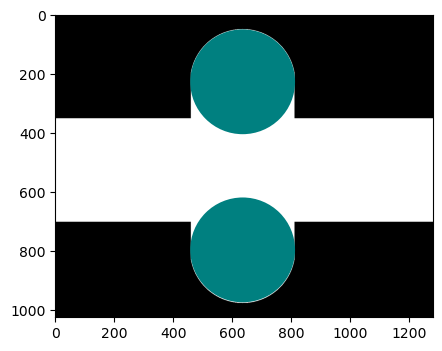

In [3]:
fig, ax = plt.subplots()
# Make some fake data with several potential wall contacts, including
# one that could be a continuous contact
imageShape = (1024, 1280)
radius = 173
centers = np.array([[225, 635], [795, 635]])

# Create a cross-shaped channel, with some parts on the ends
maskArr = crossMask(imageShape, xlim=np.array([460, 810]), ylim=np.array([350, 700]))

semiCircleMask = mergeMasks(np.array([rectMask(imageShape, corner=np.array([0,400]), dimensions=np.array([200, 500])),
                             circularMask(imageShape, np.array([225, 635]), radius+5)]),
                           signs=np.array([1,-1], dtype=np.int16)) 

listOfMasks = np.array([maskArr,
                        semiCircleMask,
                        semiCircleMask[::-1]])
maskArr = mergeMasks(listOfMasks, signs=np.array([1,-1,-1], dtype=np.int16))


ax.imshow(maskArr*255)
for i in range(len(centers)):
   c = plt.Circle(centers[i][::-1], radius, label='Detected particles', color='teal', linewidth=2)
   ax.add_artist(c)

plt.show()

[-1.2939981681629065, 1.2939981681629065]


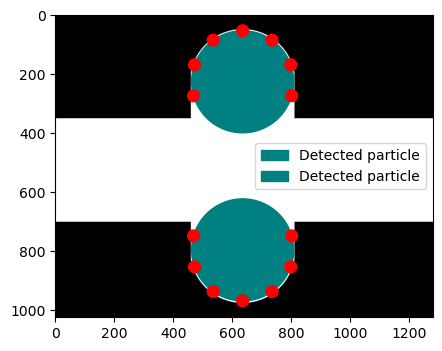

In [4]:
# Actual contact detection
numContacts, betaArr, g2AvgArr = detectWallContacts(centers, np.repeat(radius, len(centers)), maskArr, contactPadding=10)

# Draw on all of the found boundary contacts
fig, ax = plt.subplots()

ax.imshow(maskArr*255)

for i in range(len(centers)):
    # particle itself
    c = plt.Circle(centers[i][::-1], radius, label='Detected particle', color='teal')
    ax.add_artist(c)
    
    # Now add contacts
    for j in range(numContacts[i]):
        contactPoint = centers[i] + radius * np.array([np.cos(betaArr[i][j]), np.sin(betaArr[i][j])])
        cc = plt.Circle(contactPoint[::-1], 20, color='red')
        ax.add_artist(cc)
ax.legend()
plt.show()